# Titulo

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
## Imports
import pickle as pk
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from IPython.display import clear_output
import sklearn.neural_network as sknn

# Leitura e exploração dos dados

There are 39.92506244796004% of nominal cases


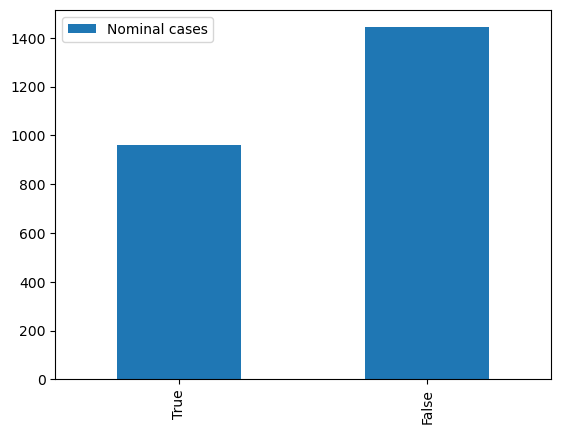

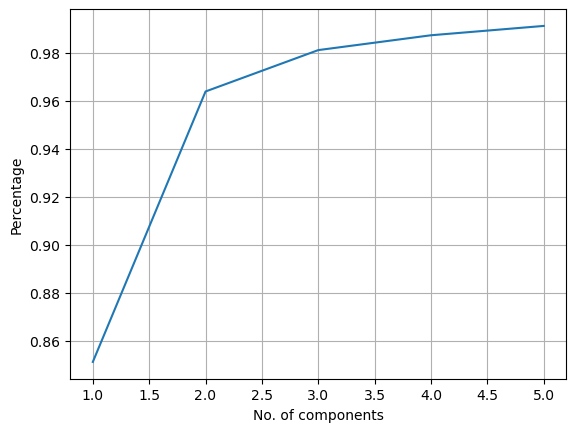

In [3]:
#path = "/content/drive/MyDrive/Colab Notebooks/TCC/"
path = "output/"
with open(path+"Tsdata.pickle", "rb") as fname:
    ([Xts]) = pk.load(fname)

with open(path+"alldata_info.pickle", "rb") as fname:
    (df2save) = pk.load(fname)

df2save['target'] = (df2save['case'] == 'A') | (df2save['case'] == 'B') | (df2save['case'] == 'C') | (df2save['case'] == 'R')
df2save['target'].value_counts().sort_values().plot(kind='bar')
plt.legend({'Nominal cases'})

print('There are ' + str(df2save['target'].sum()/len(df2save['target'])*100) + '% of nominal cases')

y = df2save['target']

pctExplVar = 0.99
pca = PCA(n_components=pctExplVar)
Xtsred = pca.fit_transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()

In [4]:
Xts.shape, Xtsred.shape

((2402, 48), (2402, 5))

In [ ]:
Xtsred[0:5,:]

array([[-5.53551908,  1.17782852,  0.2242756 , -0.15904104, -0.24356281],
       [-5.68152683,  1.0116827 ,  0.15158924, -0.10148506, -0.08661173],
       [-5.64041655,  0.8850916 ,  0.1326918 ,  0.03178893,  0.11990451],
       [-5.74539635,  1.20623889,  0.24005609, -0.17148133, -0.23251438],
       [-5.68920261,  1.07014931,  0.13065075, -0.13051693, -0.0616693 ]])

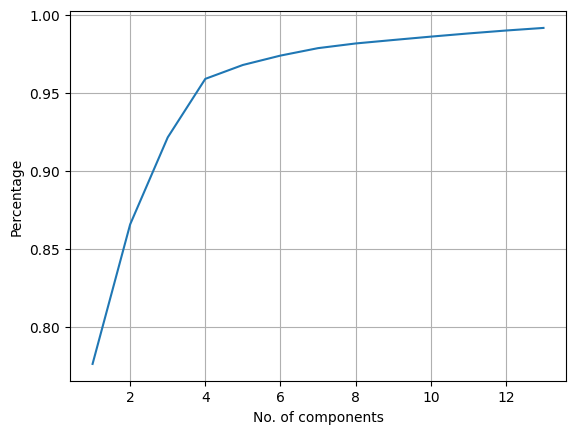

2402
2012 None


In [ ]:
def reject_outliers(data, m = 4.):
    data = data[:,0]
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev.all() else np.zeros(len(d))
    return s<m

map = reject_outliers(Xtsred)

pctExplVar = 0.99
pca2 = PCA(n_components=pctExplVar)

map_xts = reject_outliers(Xts)
Xtsred_filtered = pca2.fit_transform(Xts[map_xts])

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca2.explained_variance_ratio_)))+1,np.cumsum(pca2.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()
print(sum(map_xts),print(len(Xts)))

Utilizando o PCA encontrei alguns casos bem claros de outliers. Removendo-os e comparando os resultados no desempenho observei que o metodo ridge melhorou significativamente, ficando comparavel aos outros sem necessitar de um parameter search. Entretanto o score médio continua menor que quando comprado ao caso sem PCA.

1) Por que o caso sem PCA não tem problemas com outliers

2) Por que o caso com PCA performa tão mal

383 2019 2402


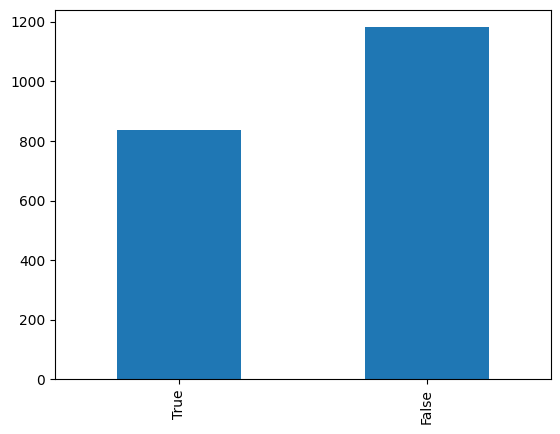

<Axes: >

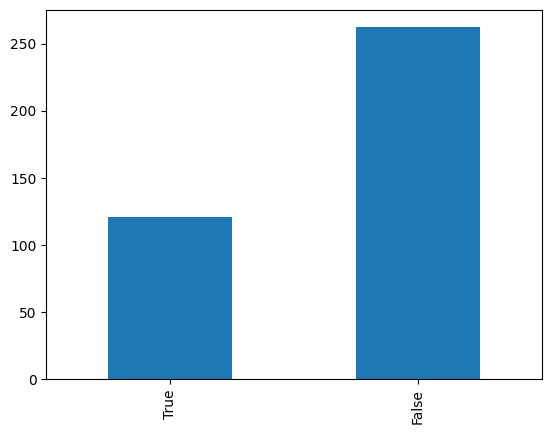

In [ ]:
print(np.sum(np.invert(map)),np.sum(map),len(map))
df2save['target'].loc[map].value_counts().sort_values().plot(kind='bar')
plt.show()
plt.figure()
df2save['target'].loc[np.invert(map)].value_counts().sort_values().plot(kind='bar')


Outliers tem caracteristica similar aos não outliers, com uma tendencia um pouco maior para falsos

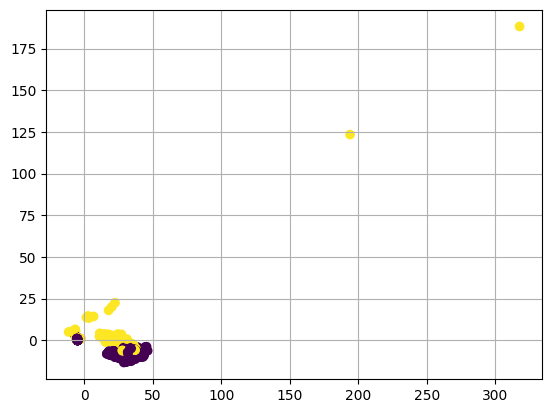

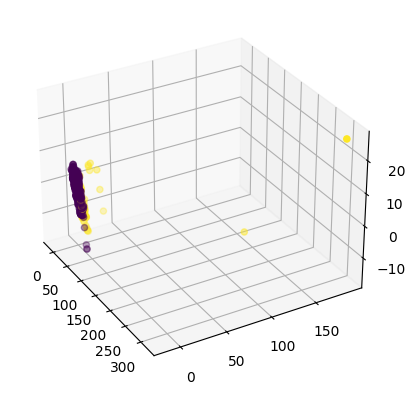

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[:,0],Xtsred[:,1],c = y)
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[:,0],Xtsred[:,1],Xtsred[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


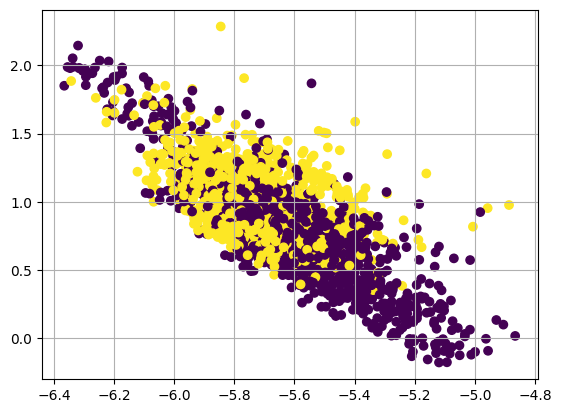

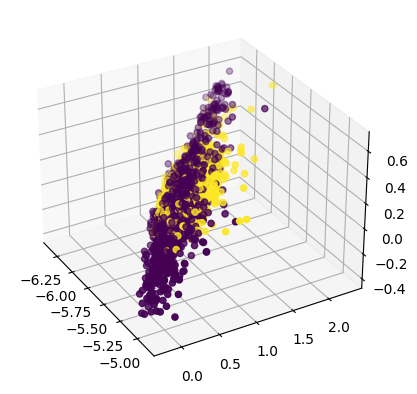

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[map,0],Xtsred[map,1],c = y[map])
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


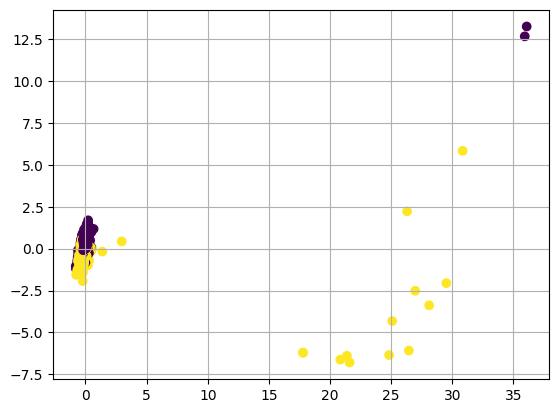

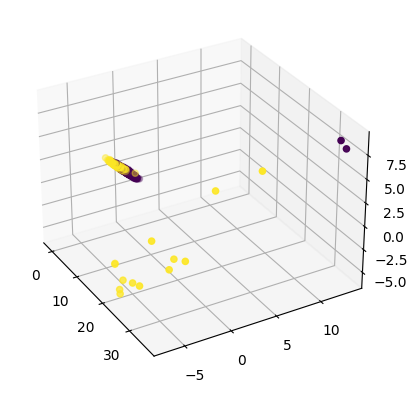

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],c = y[map_xts])
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],Xtsred_filtered[:,2],c = y[map_xts])
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()

## NN testing

In [ ]:
import tensorflow as tf
from tensorflow import keras

X0 = StandardScaler().fit_transform(X=Xts)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y,test_size=0.4,random_state=0)

layer_size = 16
model = keras.Sequential()
model.add(keras.layers.InputLayer(48))

model.add(keras.layers.Dense(layer_size,activation="tanh"))

model.add(keras.layers.Dense(1,activation="tanh"))

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X0_train, y0_train, epochs=10,
                    validation_data=(X0_test, y0_test),
                    verbose=1, callbacks=[])

Epoch 1/10
46/46 [==============================] - 1s 9ms/step - loss: 1.2975 - precision_6: 0.3566 - recall_6: 0.3191 - val_loss: 0.8938 - val_precision_6: 0.6014 - val_recall_6: 0.2161
Epoch 2/10
46/46 [==============================] - 0s 4ms/step - loss: 0.7975 - precision_6: 0.6560 - recall_6: 0.2549 - val_loss: 0.6801 - val_precision_6: 0.8294 - val_recall_6: 0.6106
Epoch 3/10
46/46 [==============================] - 0s 7ms/step - loss: 0.6459 - precision_6: 0.8542 - recall_6: 0.4492 - val_loss: 0.5161 - val_precision_6: 0.8351 - val_recall_6: 0.4070
Epoch 4/10
46/46 [==============================] - 0s 9ms/step - loss: 0.4986 - precision_6: 0.8200 - recall_6: 0.5116 - val_loss: 0.4322 - val_precision_6: 0.8754 - val_recall_6: 0.6181
Epoch 5/10
46/46 [==============================] - 0s 8ms/step - loss: 0.4453 - precision_6: 0.9009 - recall_6: 0.5508 - val_loss: 0.3889 - val_precision_6: 0.9504 - val_recall_6: 0.6256
Epoch 6/10
46/46 [==============================] - 1s 11ms/

In [ ]:
X = StandardScaler().fit_transform(X=Xtsred[map,:])

X_train, X_test, y_train, y_test = train_test_split(X, y[map],test_size=0.4,random_state=0)

layer_size = 16
model = keras.Sequential()
model.add(keras.layers.InputLayer(5))

model.add(keras.layers.Dense(layer_size,activation="tanh"))

model.add(keras.layers.Dense(1,activation="tanh"))

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[])

Epoch 1/10
38/38 [==============================] - 4s 32ms/step - loss: 4.6202 - precision_7: 0.2151 - recall_7: 0.1603 - val_loss: 4.5700 - val_precision_7: 0.1923 - val_recall_7: 0.1327
Epoch 2/10
38/38 [==============================] - 1s 22ms/step - loss: 4.2835 - precision_7: 0.2308 - recall_7: 0.1623 - val_loss: 4.4744 - val_precision_7: 0.2056 - val_recall_7: 0.1504
Epoch 3/10
38/38 [==============================] - 1s 17ms/step - loss: 4.2111 - precision_7: 0.2297 - recall_7: 0.1643 - val_loss: 4.3564 - val_precision_7: 0.2101 - val_recall_7: 0.1475
Epoch 4/10
38/38 [==============================] - 1s 18ms/step - loss: 4.1055 - precision_7: 0.2523 - recall_7: 0.1663 - val_loss: 4.2830 - val_precision_7: 0.2039 - val_recall_7: 0.1239
Epoch 5/10
38/38 [==============================] - 1s 14ms/step - loss: 3.9903 - precision_7: 0.2799 - recall_7: 0.1643 - val_loss: 3.9718 - val_precision_7: 0.2443 - val_recall_7: 0.1268
Epoch 6/10
38/38 [==============================] - 1s 

In [ ]:
X = StandardScaler().fit_transform(X=Xtsred_filtered)

X_train, X_test, y_train, y_test = train_test_split(X, y[map_xts],test_size=0.4,random_state=0)

layer_size = 16
model = keras.Sequential()
model.add(keras.layers.InputLayer(13))

model.add(keras.layers.Dense(layer_size,activation="tanh"))

model.add(keras.layers.Dense(1,activation="tanh"))

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[])

Epoch 1/10
38/38 [==============================] - 1s 10ms/step - loss: 2.9354 - precision_8: 0.4920 - recall_8: 0.2470 - val_loss: 2.6430 - val_precision_8: 0.5876 - val_recall_8: 0.2938
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 2.6951 - precision_8: 0.5259 - recall_8: 0.2851 - val_loss: 2.3289 - val_precision_8: 0.6455 - val_recall_8: 0.3446
Epoch 3/10
38/38 [==============================] - 0s 4ms/step - loss: 2.3507 - precision_8: 0.5674 - recall_8: 0.3213 - val_loss: 1.9905 - val_precision_8: 0.6961 - val_recall_8: 0.4011
Epoch 4/10
38/38 [==============================] - 0s 4ms/step - loss: 2.0139 - precision_8: 0.6174 - recall_8: 0.3855 - val_loss: 1.6530 - val_precision_8: 0.7652 - val_recall_8: 0.4972
Epoch 5/10
38/38 [==============================] - 0s 4ms/step - loss: 1.5841 - precision_8: 0.6647 - recall_8: 0.4578 - val_loss: 1.3553 - val_precision_8: 0.7913 - val_recall_8: 0.5678
Epoch 6/10
38/38 [==============================] - 0s 4ms/

# Testing without PCA

In [ ]:
X0 = StandardScaler().fit_transform(X=Xts)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X0_train,y0_train)
y0tree = tree.predict(X0_test)

ridg = RidgeClassifier()
ridg.fit(X0_train,y0_train)
y0ridg = ridg.predict(X0_test)

svc = SVC()
svc.fit(X0_train,y0_train)
y0svc = svc.predict(X0_test)

print("Confusion matrix results:")
print(confusion_matrix(y0_test, y0tree))
print(confusion_matrix(y0_test, y0ridg))
print(confusion_matrix(y0_test, y0svc))
print()

print("Balanced accuracy")
print(metrics.balanced_accuracy_score(y0_test, y0tree))
print(metrics.balanced_accuracy_score(y0_test, y0ridg))
print(metrics.balanced_accuracy_score(y0_test, y0svc))
print()

print("F1 score")
print(metrics.f1_score(y0_test, y0tree))
print(metrics.f1_score(y0_test, y0ridg))
print(metrics.f1_score(y0_test, y0svc))
print()

print("Recall score")
print(metrics.recall_score(y0_test, y0tree))
print(metrics.recall_score(y0_test, y0ridg))
print(metrics.recall_score(y0_test, y0svc))

Confusion matrix results:
[[540  23]
 [ 19 379]]
[[553  10]
 [ 61 337]]
[[550  13]
 [ 76 322]]

Balanced accuracy
0.9557043655221042
0.9144858394994511
0.8929773199925024

F1 score
0.9475
0.9046979865771811
0.878581173260573

Recall score
0.9522613065326633
0.8467336683417085
0.8090452261306532


# Testing with PCA

In [ ]:
X = StandardScaler().fit_transform(X=Xtsred[map,:])

X_train, X_test, y_train, y_test = train_test_split(X, y[map],test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
yhtree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yhridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
yhsvc = svc.predict(X_test)

print("Confusion matrix results:")
print(confusion_matrix(y_test, yhtree))
print(confusion_matrix(y_test, yhridg))
print(confusion_matrix(y_test, yhsvc))
print()

print("Balanced accuracy")
print(metrics.balanced_accuracy_score(y_test, yhtree))
print(metrics.balanced_accuracy_score(y_test, yhridg))
print(metrics.balanced_accuracy_score(y_test, yhsvc))
print()

print("F1 score")
print(metrics.f1_score(y_test, yhtree))
print(metrics.f1_score(y_test, yhridg))
print(metrics.f1_score(y_test, yhsvc))
print()

print("Recall score")
print(metrics.recall_score(y_test, yhtree))
print(metrics.recall_score(y_test, yhridg))
print(metrics.recall_score(y_test, yhsvc))

Confusion matrix results:
[[362 107]
 [ 84 255]]
[[398  71]
 [ 78 261]]
[[405  64]
 [ 61 278]]

Balanced accuracy
0.7620337000207559
0.8092627884597241
0.8417992213395726

F1 score
0.7275320970042796
0.7779433681073025
0.8164464023494861

Recall score
0.7522123893805309
0.7699115044247787
0.8200589970501475


# Testing filtered PCA

In [ ]:
Xtsred_filtered

X = StandardScaler().fit_transform(X=Xtsred_filtered)

X_train, X_test, y_train, y_test = train_test_split(X, y[map_xts],test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
yhtree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yhridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
yhsvc = svc.predict(X_test)

print("Confusion matrix results:")
print(confusion_matrix(y_test, yhtree))
print(confusion_matrix(y_test, yhridg))
print(confusion_matrix(y_test, yhsvc))
print()

print("Balanced accuracy")
print(metrics.balanced_accuracy_score(y_test, yhtree))
print(metrics.balanced_accuracy_score(y_test, yhridg))
print(metrics.balanced_accuracy_score(y_test, yhsvc))
print()

print("F1 score")
print(metrics.f1_score(y_test, yhtree))
print(metrics.f1_score(y_test, yhridg))
print(metrics.f1_score(y_test, yhsvc))
print()

print("Recall score")
print(metrics.recall_score(y_test, yhtree))
print(metrics.recall_score(y_test, yhridg))
print(metrics.recall_score(y_test, yhsvc))

Confusion matrix results:
[[391  60]
 [ 74 280]]
[[435  16]
 [ 85 269]]
[[408  43]
 [ 45 309]]

Balanced accuracy
0.8289613789820487
0.8622051436230849
0.8887688376113345

F1 score
0.8069164265129682
0.8419405320813772
0.8753541076487252

Recall score
0.7909604519774012
0.7598870056497176
0.8728813559322034


# Parameter search:

In [ ]:
param_dist = {
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[None,10,20,30],
    "max_leaf_nodes":[None,30,40,50,60,70],
    "max_features" :[None,2,3],
    "splitter":["best"]
}

tree = DecisionTreeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
#tree_random_search = RandomizedSearchCV(tree, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = 5)
tree_random_search = GridSearchCV(tree, param_dist, verbose = 4, cv = rkf)
tree_search_result = tree_random_search.fit(X_train, y_train)

clear_output()
print(tree_search_result.best_params_)

tree = DecisionTreeClassifier(**tree_search_result.best_params_)
tree.fit(X_train,y_train)
yytree = tree.predict(X_test)

print("tree results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yytree))
print(metrics.f1_score(y_test, yytree))
print(metrics.recall_score(y_test, yytree))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhtree))
print(metrics.f1_score(y_test, yhtree))
print(metrics.recall_score(y_test, yhtree))

{'criterion': 'log_loss', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': 30, 'splitter': 'best'}
tree results
Optimized
0.8560261565635687
0.8412698412698412
0.8983050847457628
Unoptimezed
0.8289613789820487
0.8069164265129682
0.7909604519774012


In [ ]:
param_dist = {
    "alpha": sp_randFloat(0,2),
    "class_weight":["balanced",None],
    "solver":["svd","cholesky","lsqr","sparse_cg","sag","saga","lbfgs"]
}

ridg = RidgeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
ridg_random_search = RandomizedSearchCV(ridg, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
ridg_search_result = ridg_random_search.fit(X_train, y_train)

clear_output()
print(ridg_search_result.best_params_)

ridg = RidgeClassifier(**ridg_search_result.best_params_)
ridg.fit(X_train,y_train)
yyridg = ridg.predict(X_test)

print("ridg results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yyridg))
print(metrics.f1_score(y_test, yyridg))
print(metrics.recall_score(y_test, yyridg))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhridg))
print(metrics.f1_score(y_test, yhridg))
print(metrics.recall_score(y_test, yhridg))

{'alpha': 1.2471273935719447, 'class_weight': 'balanced', 'solver': 'sag'}
ridg results
Optimized
0.879671038621018
0.8643815201192251
0.8192090395480226
Unoptimezed
0.8622051436230849
0.8419405320813772
0.7598870056497176


In [ ]:
param_dist = {
    "kernel":['linear','poly', 'rbf', 'sigmoid'],
    "gamma":["auto","scale"],
    "coef0":sp_randFloat(-1,1),
    "degree":sp_randInt(2,6)
}

svc = SVC()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
svc_random_search = RandomizedSearchCV(svc, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
svc_search_result = svc_random_search.fit(X_train, y_train)

clear_output()
print(svc_search_result.best_params_)

svc = SVC(**svc_search_result.best_params_)
svc.fit(X_train,y_train)
yysvc = svc.predict(X_test)

print("SVC results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yysvc))
print(metrics.f1_score(y_test, yysvc))
print(metrics.recall_score(y_test, yysvc))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhsvc))
print(metrics.f1_score(y_test, yhsvc))
print(metrics.recall_score(y_test, yhsvc))

{'coef0': -0.4795225204487952, 'degree': 5, 'gamma': 'auto', 'kernel': 'sigmoid'}
SVC results
Optimized
0.873642376639483
0.8583569405099151
0.8559322033898306
Unoptimezed
0.8887688376113345
0.8753541076487252
0.8728813559322034
